In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as gensim

from typing import List, Union
from string import punctuation
from transformers import pipeline
from tqdm.auto import tqdm, trange
from nltk.corpus import wordnet as wn
from spacy.tokenizer import Tokenizer
from lemminflect import getAllInflections
from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
class GensimEmbedder:
    def __init__(self, embd_name: str = 'glove-wiki-gigaword-50', file=False):
        if file:
            self.embeddings = KeyedVectors.load_word2vec_format(embed_name, binary=False)
        else:
            self.embeddings = gensim.load(embd_name)
        
        self.dim = self.embeddings.vectors.shape[1]
        
        self.oov_embedding = np.mean(self.embeddings.vectors, axis=0)
        assert self.oov_embedding.shape[0] == self.dim
    
    def __contains__(self, obj):
        return obj in self.embeddings
    
    def embed_token(self, token: str):
        try:
            return self.embeddings[token]
        except KeyError:
            return self.oov_embedding
    
    def embed_context(self, context: List[str]):
        token_embeddings = [self.embed_token(token) for token in context if token in self.embeddings]
        if len(token_embeddings) == 0:
            return self.oov_embedding
        else:
            return np.mean(np.stack(token_embeddings), axis=0)

In [3]:
class WordNetCandidates:
    """
    Retrieves candidate replacements of `target` from WordNet.
    Takes synonym and hypernym lemmas from all or only verb senses.
    Optionally augments list by inflections.
    
    :param target:          Target token
    :param only_verb:       Whether to only consider verb senses
    :param use_inflections: Whether to add inflections
    :returns:               List of WordNet candidates
    """
    def __init__(self, only_verb: bool = True, use_inflections: bool = True):
        self.only_verb = only_verb
        self.use_inflections = use_inflections


    def _get_inflections(self, candidates: List[str]) -> List[str]:
        inflected_candidates = []
        
        for candidate in candidates:
            inflected_candidates.append(candidate)
        
            inflections = getAllInflections(candidate)
            
            # Only use verb senses (optional)
            if self.only_verb:
                inflections = {
                    pos: forms for pos, forms in inflections.items()
                    if pos.lower().startswith('v')
                }
            
            for forms in inflections.values():
                inflected_candidates.extend(list(forms))
        
        return inflected_candidates


    def __call__(self, target: str, **kwargs) -> List[str]:
        candidates = [target]
    
        # Find all relevant synsets
        target_synsets = wn.synsets(target)
        hypernym_synsets = []
        for target_synset in target_synsets:
            hypernym_synsets.extend(list(target_synset.hypernyms()))
    
        # Collect lemmata (as str)
        for synset in target_synsets + hypernym_synsets:
            # Only use verb senses (optional)
            if self.only_verb and synset.pos() != 'v':
                continue
        
            candidates.extend([lemma.name() for lemma in synset.lemmas()])
    
        # Add inflections using lemminflect (optional)
        if self.use_inflections:
            candidates = self._get_inflections(candidates)
    
        # Sort & clean candidates
        candidates = list(sorted(set(candidates)))
        if not candidates:
            candidates = target
        
        return candidates

In [4]:
class BERTCandidates:
    def __init__(self, bert_model="roberta-base", top_k=25):
        self.get_candidates = pipeline("fill-mask", model=bert_model, top_k=top_k)
        
    def __call__(self, targets, contexts, **kwargs):
        if isinstance(contexts, str):
            contexts = [contexts]
            
        candidates = self.get_candidates(contexts)
        candidates = [[candidate['token_str'].strip().lower() for candidate in context_candidates]
                      for context_candidates in candidates
                      ]
        candidates = [list(sorted(set(context_candidates))) for context_candidates in candidates]
        candidates = [([target] if not context_candidates else context_candidates)
                      for target, context_candidates in zip(targets, candidates)]
        
        return candidates

In [5]:
from collections import defaultdict

class WordNetBertCandidates:
    def __init__(self, bert_model='roberta-base', top_k=25):
        self.top_k = top_k
        self.wordnet_candidates = WordNetCandidates()
        self.bert = pipeline("fill-mask", model=bert_model, top_k=1000)
    
    def __call__(self, targets, contexts, **kwargs):
        wordnet_candidates = [self.wordnet_candidates(target) for target in targets]
        bert_scores = self.bert(contexts)
        
        assert len(wordnet_candidates) == len(bert_scores)
        
        candidates = []
        
        for target, context_wordnet_candidates, context_scores in zip(targets, wordnet_candidates, bert_scores):
            scores = defaultdict(lambda s: 0.0)
        
            for candidate in context_scores:
                token = candidate['token_str'].strip().lower()
                score = candidate['score']
                if token not in scores or score > scores[token]:
                    scores[token] = score
            
            context_candidates = sorted(scores.keys(), key=scores.get, reverse=True)
            context_candidates = list(context_candidates)[:self.top_k]
            
            if not context_candidates:
                context_candidates = [target]
            
            candidates.append(context_candidates)
            
        return candidates

In [6]:
class BertMetaphorDetector:
    def __init__(self, embedder, get_candidate_words):
        self.embedder = embedder
        self.get_candidate_words = get_candidate_words
        
        self.nlp = spacy.load("en_core_web_sm", disable = ['ner', 'parser', 'textcat'])
        
    
    def get_best_fit_words(self, targets: str, contexts: List[str]) -> str:
        candidates = self.get_candidate_words(targets=targets, contexts=contexts)
        best_fit_words = []
        
        for target, context, context_candidates in zip(targets, contexts, candidates):
            context_candidates = [candidate for candidate in context_candidates if candidate in self.embedder]
        
            if not context_candidates:
                best_fit_words.append(target)
                continue
            elif len(candidates) == 1:
                best_fit_words.append(candidates[0])
                continue
        
            clean_context = [
                token.lemma_ for token in self.nlp(context)
                if not token.is_stop and bool(token.lemma_.strip(punctuation).strip())
            ]
        
            context_embedding = self.embedder.embed_context(clean_context)
            context_embedding = np.atleast_2d(context_embedding)
        
            candidate_embeddings = [
                self.embedder.embed_token(candidate) for candidate in context_candidates
            ]
            candidate_embeddings = np.stack(candidate_embeddings)
        
            similarities = cosine_similarity(context_embedding, candidate_embeddings)
            similarities = similarities.reshape(-1)
        
            best_fit_words.append(context_candidates[np.argmax(similarities)])
        
        return best_fit_words

    
    def predict_scores(self,
                       targets: Union[str, List[str]],
                       contexts: Union[List[str], List[List[str]]]) -> List[float]:
        if isinstance(targets, str):
            targets = [targets]
            contexts = [contexts]
            
        assert len(targets) == len(contexts)
        
        best_fit_words = []
        start, step = 0, 64
        #pbar = tqdm(total = len(targets) // step + 1)
        while len(best_fit_words) < len(targets):
            stop = start + step
            best_fit_words_batch = self.get_best_fit_words(targets[start:stop], contexts[start:stop])
            best_fit_words.extend(best_fit_words_batch)
            start = stop
            
            #pbar.update(1)
        
        probs = []
        #for target, context, fit_word in tqdm(zip(targets, contexts, best_fit_words), total=len(targets)):
        for target, context, fit_word in zip(targets, contexts, best_fit_words):
            target_embedding = self.embedder.embed_token(target)
            target_embedding = np.atleast_2d(target_embedding)
            
            fit_word_embedding = embedder.embed_token(fit_word)
            fit_word_embedding = np.atleast_2d(fit_word_embedding)
            
            S = cosine_similarity(target_embedding, fit_word_embedding)
            S = S.reshape(-1)
            S = S.item()
            probs.append(S)
        
        return np.array(probs)

In [7]:
def evaluate(scores, labels):
    results = dict()
    
    results['scores'] = np.array(scores).copy()
    results['labels'] = np.array(labels).copy()
    
    scores = 1 - scores
    scores = np.clip(scores, 0.0, 1.0)
    
    results['precision_recall_curve'] = precision_recall_curve(labels, scores)[:2]
    results['roc_curve'] = roc_curve(labels, scores)[:2]
    results['roc_auc'] = auc(*results['roc_curve'])
    
    thresholds = np.linspace(0.0, 0.99, 98)
    y_true = labels.astype(np.int64)
    results['thresholds'] = thresholds
    results['metrics'] = dict()
    
    for tau in thresholds:
        y_pred = (scores > tau).astype(np.int64)
        results['metrics'][tau] = {
            'y_pred': y_pred.copy(),
            'precision': precision_score(y_true, y_pred, zero_division=0.0),
            'recall': recall_score(y_true, y_pred, zero_division=0.0),
            'f1': f1_score(y_true, y_pred, zero_division=0.0),
            'accuracy': accuracy_score(y_true, y_pred)
        }
    
    f1 = [results['metrics'][tau]['f1'] for tau in thresholds]
    results['best_tau'] = thresholds[np.argmax(f1)]
    
    return results

In [8]:
def display_score_distribution(scores, labels, filename=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
    bins = 100
    align = 'left'
    xx = 0.5
    font_size = 14
    plt.rcParams['font.size'] = font_size

    # Overall statistics
    #ax1.hist(scores, bins=100, color='blue')
    #ax1.set_xlabel('Cosine distance in [-1.0, 1.0]')
    #ax1.set_ylabel('# Similarities (binned)')
    #ax1.set_title('Combined statistics')
    
    sns.histplot(scores, kde=False, bins=bins, ax=ax1,
                 stat='density', color='blue', element='step',
                 label='Overall statistics')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.axvline(np.median(scores),
                color='black', linestyle='dashed')
    ax1.set_title('Overall statistics', pad=0.4)
    #ax1.set_ylim([0, ax1.get_ylim()[1]])
    ax1.set_xlabel('Cosine similarity in [-1.0, 1.0]')
    
    med = np.median(scores)
    ax2.text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                    horizontalalignment=align,
                    verticalalignment='center',
                    transform=ax1.transAxes,
                    size=12)

    # Metaphor statistics
    #ax2.hist(scores[labels == 1], bins=100, color='tomato', label='Metaphor statistics')
    #ax2.set_xlabel('Cosine similarity in [-1.0, 1.0]')
    #ax2.set_ylabel('# Similarities (binned)')
    #ax2.set_title('Metaphor statistics')
    
    sns.histplot(scores[labels == 1], kde=False, bins=bins, ax=ax2,
                 stat='density', color='tomato', element='step',
                 label='Metaphor statistics')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.axvline(np.median(scores[labels == 1]),
                color='black', linestyle='dashed')
    ax2.set_title('Metaphor statistics', pad=0.4)
    #ax2.set_ylim([0, ax2.get_ylim()[1]])
    ax2.set_xlabel('Cosine similarity in [-1.0, 1.0]')
    
    med = np.median(scores[labels == 1])
    ax2.text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                    horizontalalignment=align,
                    verticalalignment='center',
                    transform=ax2.transAxes,
                    size=12)
    

    # Literal statistics
    sns.histplot(scores[labels == 0], kde=False, bins=bins, ax=ax3,
                 stat='density', color='forestgreen', element='step',
                 label='Literal statistics')
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.axvline(np.median(scores[labels == 0]),
                color='black', linestyle='dashed')
    ax3.set_title('Literal statistics', pad=0.4)
    #ax3.set_ylim([0, ax3.get_ylim()[1]])
    #ax3.hist(scores[labels == 0], bins=100, color='forestgreen', label='Literal statistics')
    ax3.set_xlabel('Cosine similarity in [-1.0, 1.0]')
    #ax3.set_ylabel('# Similarities (binned)')
    #ax3.set_title('Literal statistics')
    #ax2.legend()
    med = np.median(scores[labels == 0])
    ax3.text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                    horizontalalignment=align,
                    verticalalignment='center',
                    transform=ax3.transAxes,
                    size=12)
    
    
    if filename is not None:
        fig.savefig("figures/{}.png".format(filename), dpi=300)

    plt.show()

def display_score_statistics(scores, labels):
    #full_scores = scores.copy()
    #full_labels = labels.copy()
    
    #mask = (0.01 < full_scores) & (full_scores < 0.99)
    #scores = full_scores[mask]
    #labels = full_labels[mask]
    
    scores = np.round(scores, 2)

    all_scores_summary = pd.DataFrame(data=scores, index=None, columns=["All scores"]).describe()

    metaphor_scores_summary = pd.DataFrame(data=scores[labels == 1], index=None, columns=["Metaphor scores"])
    metaphor_scores_summary = metaphor_scores_summary.describe()

    literal_scores_summary = pd.DataFrame(data=scores[labels == 0], index=None, columns=["Literal scores"])
    literal_scores_summary = literal_scores_summary.describe()

    stats = pd.concat([all_scores_summary, metaphor_scores_summary, literal_scores_summary], axis=1)
    return stats


def display_evaluation_metrics(results):
    metrics = pd.DataFrame.from_records(
        [{metric: score for metric, score in results['metrics'][tau].items()
          if metric != 'y_pred'}
         for tau in results['thresholds']]
    )
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 13), sharex=True, sharey=True)

    # Precision-Recall curve
    precision, recall = results['precision_recall_curve']
    ax1.step(recall, precision, where='post')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax1.set_title("Precision-Recall curve")
    ax1.set_aspect('equal', adjustable='box')

    # Receiver-Operating charateristic
    lw = 2
    fpr, tpr = results['roc_curve']
    roc_auc = results['roc_auc']
    ax2.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('Receiver operating characteristic')
    ax2.legend(loc="upper left")
    ax2.set_aspect('equal', adjustable='box')

    # Metrics vs. threshold
    for metric in metrics:
        ax3.plot(results['thresholds'], metrics[metric], label=metric)

    ax3.legend(loc="upper left")
    ax3.set_xlabel("Threshold")
    ax3.set_ylabel("Metric")
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title("Performance")

    plt.show()

In [9]:
# Use implementation from
# https://github.com/Sleemanmunk/approximate-randomization/blob/master/approximate_randomization.py

def approximate_randomization_test(sample1, sample2, score_func, repetitions=10000):
    assert len(sample1) == len(sample2)
    n = len(sample1)
    
    true_diff = np.abs(score_func(sample1) - score_func(sample2))
    
    c = 0
    for _ in range(repetitions):
        shuffle = np.random.rand(n)  < 0.5
        sample1_new = np.select([shuffle, ~ shuffle], [sample1, sample2])
        sample2_new = np.select([shuffle, ~ shuffle], [sample2, sample1])
        score_diff = np.abs(score_func(sample1_new) - score_func(sample2_new))
        
        c += (1 if score_diff >= true_diff else 0)
    
    return (c+1) / (repetitions + 1)

In [10]:
embedders = {
    'glove': GensimEmbedder("glove-wiki-gigaword-300"),
    'word2vec': GensimEmbedder("word2vec-google-news-300"),
    'fasttext': GensimEmbedder("fasttext-wiki-news-subwords-300")
}

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
candidates = {
    'RoBERTa + only best': BERTCandidates(bert_model="roberta-base", top_k=1),
    'RoBERTa + top 25': BERTCandidates(bert_model="roberta-base", top_k=25),
    'WordNet RoBERTa + only best': WordNetBertCandidates(bert_model="roberta-base", top_k=1),
    'WordNet RoBERTa + top 25': WordNetBertCandidates(bert_model="roberta-base", top_k=25),
    #'BERT + only best': BERTCandidates(bert_model='bert-base-uncased', top_k=1),
    #'BERT + top 25': BERTCandidates(bert_model='bert-base-uncased', top_k=25),
}

In [13]:
mask_token = candidates['RoBERTa + only best'].get_candidates.tokenizer.mask_token

### 1st experiment: MohX-Full data

In [14]:
# Load Mohammad et al. data
data = pd.read_csv("data/mohammad.txt", sep='\t', skipfooter=2, engine='python')

# Targets
targets = data['term'].tolist()

# Contexts
nlp = spacy.load("en_core_web_sm", disable = ['ner', 'parser', 'textcat'])
contexts = data['sentence'].tolist()
contexts = [re.sub(r'<b>.*</b>', mask_token, context.lower()) for context in contexts]   # Remove targets
#contexts = [
#    [token.lemma_ for token in nlp(context) 
#     if not token.is_stop and bool(token.lemma_.strip(punctuation).strip())]
#    for context in contexts
#]

# Labels
labels = data['class']
labels = [(1 if label == 'metaphorical' else 0) for label in labels]
labels_ = np.array(labels)

# Confidences
confidences = data['confidence']
confidences = np.array(confidences)

assert len(targets) == len(contexts) == len(labels) == len(confidences)

In [15]:
#embedder = embedders['glove']
#candidate_finder = WordNetBertCandidates(bert_model="roberta-base", top_k=25)
#classifier = BertMetaphorDetector(embedder, candidate_finder)

#scores_ = classifier.predict_scores(targets, contexts)

In [16]:
#results = evaluate(scores_, labels_)
#display_score_distribution(results['scores'], results['labels'])

In [17]:
print("Number of metaphorical targets: {}".format(np.sum(labels)))
print("Number of literal targets: {}".format(len(labels) - np.sum(labels)))

Number of metaphorical targets: 410
Number of literal targets: 1229


In [18]:
results = dict()
for embedding_name, embedder in embedders.items():
    for mode, candidate_finder in candidates.items():
        classifier = BertMetaphorDetector(embedder, candidate_finder)
        
        scores_ = classifier.predict_scores(targets, contexts)
        #mask = ~ np.isnan(scores_)
        #scores = scores_[mask]
        #labels = labels_[mask]
        scores = scores_.copy()
        labels = labels_.copy()
        
        results[(embedding_name, mode)] = evaluate(scores, labels)
        print("Finished evaluating {} with {}".format(embedding_name, mode))

Finished evaluating glove with RoBERTa + only best
Finished evaluating glove with RoBERTa + top 25
Finished evaluating glove with WordNet RoBERTa + only best
Finished evaluating glove with WordNet RoBERTa + top 25
Finished evaluating word2vec with RoBERTa + only best
Finished evaluating word2vec with RoBERTa + top 25
Finished evaluating word2vec with WordNet RoBERTa + only best
Finished evaluating word2vec with WordNet RoBERTa + top 25
Finished evaluating fasttext with RoBERTa + only best
Finished evaluating fasttext with RoBERTa + top 25
Finished evaluating fasttext with WordNet RoBERTa + only best
Finished evaluating fasttext with WordNet RoBERTa + top 25


In [19]:
best_f1 = np.zeros((len(candidates.keys()), len(embedders.keys())))
modes = list(sorted(candidates.keys()))
embedding_names = list(sorted(embedders.keys()))

for i, mode in enumerate(modes):
    for j, embedding_name in enumerate(embedding_names):
        current_results = results[(embedding_name, mode)]
        best_tau = current_results['best_tau']
        best_f1[i, j] = current_results['metrics'][best_tau]['f1']

best_f1_table = pd.DataFrame(data=np.round(best_f1, 3), index=modes, columns=embedding_names)
best_f1_table

,fasttext,glove,word2vec
RoBERTa + only best,0.428,0.428,0.412
RoBERTa + top 25,0.424,0.451,0.407
WordNet RoBERTa + only best,0.428,0.428,0.412
WordNet RoBERTa + top 25,0.423,0.452,0.407


In [20]:
print(best_f1_table.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  fasttext &  glove &  word2vec \\
\midrule
RoBERTa + only best         &     0.428 &  0.428 &     0.412 \\
RoBERTa + top 25            &     0.424 &  0.451 &     0.407 \\
WordNet RoBERTa + only best &     0.428 &  0.428 &     0.412 \\
WordNet RoBERTa + top 25    &     0.423 &  0.452 &     0.407 \\
\bottomrule
\end{tabular}



In [21]:
metaphor_rate = np.sum(labels_) / len(labels_)

best_results = results[("glove", 'RoBERTa + only best')]
best_tau = best_results['best_tau']
predictions = best_results['metrics'][best_tau]['y_pred']
labels = best_results['labels']

num_comparisons = 1000
p = approximate_randomization_test(
    np.array([best_results['metrics'][best_tau]['f1']] * num_comparisons),
    np.array([f1_score(np.random.binomial(1, metaphor_rate, size=(len(labels),)), labels)
              for _ in range(num_comparisons)]),
    np.mean
)

print("Significant: {} with p-values = {}".format(p < 0.005, p))

Significant: True with p-values = 9.999000099990002e-05


In [22]:
display_res = results[('glove', 'RoBERTa + only best')]

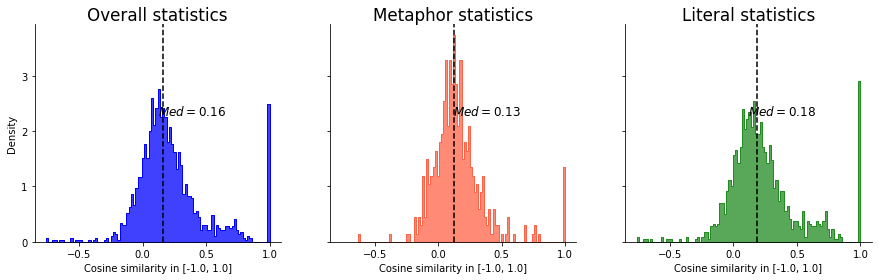

In [23]:
display_score_distribution(display_res['scores'], display_res['labels'], filename='bert_moh_unbalanced')

### 2nd experiment: MohX-Balanced data

In [24]:
metaphorical_indices, = np.where(labels_ == 1)
literal_indices, = np.where(labels_ == 0)

metaphorical_confidences = np.array([confidences[index] for index in metaphorical_indices])
literal_confidences = np.array([confidences[index] for index in literal_indices])

metaphorical_indices = metaphorical_indices[np.argsort(metaphorical_confidences)[::-1]]
literal_indices = literal_indices[np.argsort(literal_confidences)[::-1]]

metaphorical_targets = [targets[index] for index in metaphorical_indices]
metaphorical_contexts = [contexts[index] for index in metaphorical_indices]
metaphorical_labels = np.array([labels_[index] for index in metaphorical_indices])
assert len(metaphorical_targets) == len(metaphorical_contexts) == len(metaphorical_labels)

literal_targets = [targets[index] for index in literal_indices]
literal_contexts = [contexts[index] for index in literal_indices]
literal_labels = np.array([labels_[index] for index in literal_indices])
assert len(literal_labels) == len(literal_contexts) == len(literal_targets)

In [25]:
N = len(metaphorical_indices)

balanced_targets = metaphorical_targets + literal_targets[:N]
balanced_contexts = metaphorical_contexts + literal_contexts[:N]
balanced_labels_ = np.concatenate([metaphorical_labels, literal_labels[:N]])

In [26]:
num_metaphorical = len(metaphorical_targets)
total = len(metaphorical_targets) + len(literal_targets[:N])

print("Number of metaphorical targets: {} ({:.2f}%)".format(num_metaphorical, 100 * num_metaphorical / total))
print("Number of literal targets: {}".format(total - num_metaphorical))

Number of metaphorical targets: 410 (50.00%)
Number of literal targets: 410


In [27]:
balanced_results = dict()
for embedding_name, embedder in embedders.items():
    for mode, candidate_finder in candidates.items():
        classifier = BertMetaphorDetector(embedder, candidate_finder)
        
        scores_ = classifier.predict_scores(balanced_targets, balanced_contexts)
        mask = ~ np.isnan(scores_)
        scores = scores_[mask]
        balanced_labels = balanced_labels_[mask]
        
        balanced_results[(embedding_name, mode)] = evaluate(scores, balanced_labels)

In [28]:
best_f1 = np.zeros((len(candidates.keys()), len(embedders.keys())))
modes = list(sorted(candidates.keys()))
embedding_names = list(sorted(embedders.keys()))

for i, mode in enumerate(modes):
    for j, embedding_name in enumerate(embedding_names):
        current_results = balanced_results[(embedding_name, mode)]
        best_tau = current_results['best_tau']
        best_f1[i, j] = current_results['metrics'][best_tau]['f1']

best_f1_table = pd.DataFrame(data=np.round(best_f1, 3), index=modes, columns=embedding_names)
best_f1_table

,fasttext,glove,word2vec
RoBERTa + only best,0.683,0.685,0.657
RoBERTa + top 25,0.673,0.682,0.677
WordNet RoBERTa + only best,0.683,0.685,0.657
WordNet RoBERTa + top 25,0.671,0.681,0.677


In [29]:
print(best_f1_table.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  fasttext &  glove &  word2vec \\
\midrule
RoBERTa + only best         &     0.683 &  0.685 &     0.657 \\
RoBERTa + top 25            &     0.673 &  0.682 &     0.677 \\
WordNet RoBERTa + only best &     0.683 &  0.685 &     0.657 \\
WordNet RoBERTa + top 25    &     0.671 &  0.681 &     0.677 \\
\bottomrule
\end{tabular}



In [30]:
metaphor_rate = np.sum(balanced_labels_) / len(balanced_labels_)

best_results = balanced_results[("glove", 'RoBERTa + only best')]
best_tau = best_results['best_tau']
predictions = best_results['metrics'][best_tau]['y_pred']
labels = best_results['labels']

num_comparisons = 1000
p = approximate_randomization_test(
    np.array([best_results['metrics'][best_tau]['f1']] * num_comparisons),
    np.array([f1_score(np.random.binomial(1, metaphor_rate, size=(len(labels),)), labels)
              for _ in range(num_comparisons)]),
    np.mean
)

print("Significant: {} with p-values = {}".format(p < 0.005, p))

Significant: True with p-values = 9.999000099990002e-05


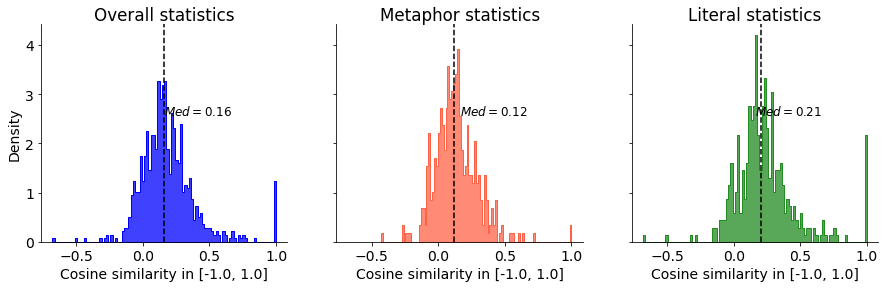

In [31]:
glove_res = balanced_results[('glove', 'RoBERTa + top 25')]
display_score_distribution(glove_res['scores'], glove_res['labels'], filename="bert_moh_balanced")

### 3rd experiment: VUA data

In [15]:
vua_corpus_test = pd.read_csv("data/naacl_flp/vuamc_corpus_test.csv")

In [33]:
vua_targets = []
vua_contexts = []
vua_labels = []
vua_texts = []

# Use whitespace tokenization from
# https://stackoverflow.com/questions/65160277/spacy-tokenizer-with-only-whitespace-rule
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)

with open("data/naacl_flp/verb_tokens_test.csv") as vua_test_tokens:
    for line in tqdm(vua_test_tokens.readlines()):
        identifier, label = line.strip().split(',')
        txt_id, sentence_id, token_id = identifier.split('_')
        sentence_id = int(sentence_id)
        token_id = int(token_id) - 1
        
        assert token_id >= 0
        
        sentence = vua_corpus_test.loc[(vua_corpus_test['txt_id'] == txt_id) &
                                       (vua_corpus_test['sentence_id'] == sentence_id)]
        sentence = sentence['sentence_txt'].item()
        vua_texts.append(sentence)
        sentence = sentence.lower().split()
        remove_metaphor_prefix = (lambda s: s[2:] if s.startswith('M_') else s)
        sentence = [remove_metaphor_prefix(token) for token in sentence]
        target = nlp(" ".join(sentence))[token_id].lemma_
        
        sentence[token_id] = mask_token
        context = " ".join(sentence)
        
        vua_contexts.append(context)
        vua_targets.append(target)
        vua_labels.append(int(label))

vua_labels_ = np.array(vua_labels)

  0%|          | 0/5873 [00:00<?, ?it/s]

In [34]:
num_metaphorical = np.sum(vua_labels_)
total = len(vua_labels_)

print("Number of metaphorical targets: {} ({:.2f}%)".format(num_metaphorical, 100 * num_metaphorical / total))
print("Number of literal targets: {}".format(total - num_metaphorical))

Number of metaphorical targets: 1761 (29.98%)
Number of literal targets: 4112


In [35]:
vua_results = dict()
for embedding_name, embedder in embedders.items():
    for mode, candidate_finder in candidates.items():
        classifier = BertMetaphorDetector(embedder, candidate_finder)
        
        scores_ = classifier.predict_scores(vua_targets, vua_contexts)
        #mask = ~ np.isnan(scores_)
        #scores = scores_[mask]
        #vua_labels = vua_labels_[mask]
        scores = scores_.copy()
        labels = vua_labels_.copy()
        
        vua_results[(embedding_name, mode)] = evaluate(scores, labels)
        print("Completed evaluating {} with {}".format(embedding_name, mode))

Completed evaluating glove with RoBERTa + only best
Completed evaluating glove with RoBERTa + top 25
Completed evaluating glove with WordNet RoBERTa + only best
Completed evaluating glove with WordNet RoBERTa + top 25
Completed evaluating word2vec with RoBERTa + only best
Completed evaluating word2vec with RoBERTa + top 25
Completed evaluating word2vec with WordNet RoBERTa + only best
Completed evaluating word2vec with WordNet RoBERTa + top 25
Completed evaluating fasttext with RoBERTa + only best
Completed evaluating fasttext with RoBERTa + top 25
Completed evaluating fasttext with WordNet RoBERTa + only best
Completed evaluating fasttext with WordNet RoBERTa + top 25


In [36]:
vua_table = np.zeros((len(candidates.keys()), 4))
modes = list(sorted(candidates.keys()))
#embedding_names = list(sorted(embedders.keys()))
metrics = ["precision", "recall", "f1", "accuracy"]

for i, mode in enumerate(modes):
    for j, metric in enumerate(metrics):
        current_results = vua_results[("word2vec", mode)]
        best_tau = current_results['best_tau']
        vua_table[i, j] = current_results['metrics'][best_tau][metric]

best_vua_table = pd.DataFrame(data=np.round(vua_table, 3), index=modes, columns=metrics)
best_vua_table

,precision,recall,f1,accuracy
RoBERTa + only best,0.309,0.825,0.450,0.395
RoBERTa + top 25,0.326,0.867,0.474,0.423
WordNet RoBERTa + only best,0.309,0.825,0.450,0.395
WordNet RoBERTa + top 25,0.328,0.863,0.475,0.428


In [37]:
print(best_vua_table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &     f1 &  accuracy \\
\midrule
RoBERTa + only best         &      0.309 &   0.825 &  0.450 &     0.395 \\
RoBERTa + top 25            &      0.326 &   0.867 &  0.474 &     0.423 \\
WordNet RoBERTa + only best &      0.309 &   0.825 &  0.450 &     0.395 \\
WordNet RoBERTa + top 25    &      0.328 &   0.863 &  0.475 &     0.428 \\
\bottomrule
\end{tabular}



In [38]:
metaphor_rate = np.sum(vua_labels_) / len(vua_labels_)

best_results = vua_results[("word2vec", 'RoBERTa + top 25')]
best_tau = best_results['best_tau']
predictions = best_results['metrics'][best_tau]['y_pred']
labels = best_results['labels']

num_comparisons = 1000
p = approximate_randomization_test(
    np.array([best_results['metrics'][best_tau]['f1']] * num_comparisons),
    np.array([f1_score(np.random.binomial(1, metaphor_rate, size=(len(labels),)), labels)
              for _ in range(num_comparisons)]),
    np.mean
)

print("Significant: {} with p-values = {}".format(p < 0.005, p))

Significant: True with p-values = 9.999000099990002e-05


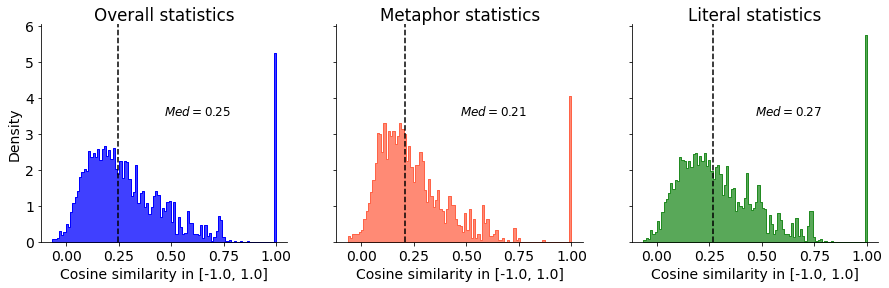

In [39]:
display_res = vua_results[("word2vec", 'RoBERTa + top 25')]
display_score_distribution(display_res['scores'], display_res['labels'])

### 4th Experiment: VUA All POS

In [16]:
vua_targets = []
vua_contexts = []
vua_labels = []
vua_texts = []

# Use whitespace tokenization from
# https://stackoverflow.com/questions/65160277/spacy-tokenizer-with-only-whitespace-rule
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)

with open("data/naacl_flp/all_pos_token_test.csv") as vua_test_tokens:
    for line in tqdm(vua_test_tokens.readlines()):
        identifier, label = line.strip().split(',')
        txt_id, sentence_id, token_id = identifier.split('_')
        sentence_id = int(sentence_id)
        token_id = int(token_id) - 1
        
        assert token_id >= 0
        
        sentence = vua_corpus_test.loc[(vua_corpus_test['txt_id'] == txt_id) &
                                       (vua_corpus_test['sentence_id'] == sentence_id)]
        sentence = sentence['sentence_txt'].item()
        vua_texts.append(sentence)
        sentence = sentence.lower().split()
        remove_metaphor_prefix = (lambda s: s[2:] if s.startswith('M_') else s)
        sentence = [remove_metaphor_prefix(token) for token in sentence]
        target = nlp(" ".join(sentence))[token_id].lemma_
        
        sentence[token_id] = mask_token
        context = " ".join(sentence)
        
        vua_contexts.append(context)
        vua_targets.append(target)
        vua_labels.append(int(label))

vua_labels_ = np.array(vua_labels)

  0%|          | 0/22196 [00:00<?, ?it/s]

In [17]:
num_metaphorical = np.sum(vua_labels_)
total = len(vua_labels_)

print("Number of metaphorical targets: {} ({:.2f}%)".format(num_metaphorical, 100 * num_metaphorical / total))
print("Number of literal targets: {}".format(total - num_metaphorical))

Number of metaphorical targets: 3982 (17.94%)
Number of literal targets: 18214


In [18]:
vua_results = dict()
for embedding_name, embedder in embedders.items():
    for mode, candidate_finder in candidates.items():
        classifier = BertMetaphorDetector(embedder, candidate_finder)
        
        scores_ = classifier.predict_scores(vua_targets, vua_contexts)
        #mask = ~ np.isnan(scores_)
        #scores = scores_[mask]
        #vua_labels = vua_labels_[mask]
        scores = scores_.copy()
        labels = vua_labels_.copy()
        
        vua_results[(embedding_name, mode)] = evaluate(scores, labels)
        print("Completed evaluating {} with {}".format(embedding_name, mode))

Completed evaluating glove with RoBERTa + only best
Completed evaluating glove with RoBERTa + top 25
Completed evaluating glove with WordNet RoBERTa + only best
Completed evaluating glove with WordNet RoBERTa + top 25
Completed evaluating word2vec with RoBERTa + only best
Completed evaluating word2vec with RoBERTa + top 25
Completed evaluating word2vec with WordNet RoBERTa + only best
Completed evaluating word2vec with WordNet RoBERTa + top 25
Completed evaluating fasttext with RoBERTa + only best
Completed evaluating fasttext with RoBERTa + top 25
Completed evaluating fasttext with WordNet RoBERTa + only best
Completed evaluating fasttext with WordNet RoBERTa + top 25


In [19]:
vua_table = np.zeros((len(candidates.keys()), 4))
modes = list(sorted(candidates.keys()))
#embedding_names = list(sorted(embedders.keys()))
metrics = ["precision", "recall", "f1", "accuracy"]

for i, mode in enumerate(modes):
    for j, metric in enumerate(metrics):
        current_results = vua_results[("word2vec", mode)]
        best_tau = current_results['best_tau']
        vua_table[i, j] = current_results['metrics'][best_tau][metric]

best_vua_table = pd.DataFrame(data=np.round(vua_table, 3), index=modes, columns=metrics)
best_vua_table

,precision,recall,f1,accuracy
RoBERTa + only best,0.183,0.791,0.297,0.328
RoBERTa + top 25,0.194,0.847,0.315,0.341
WordNet RoBERTa + only best,0.183,0.791,0.297,0.328
WordNet RoBERTa + top 25,0.194,0.850,0.316,0.340


In [20]:
print(best_vua_table.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &     f1 &  accuracy \\
\midrule
RoBERTa + only best         &      0.183 &   0.791 &  0.297 &     0.328 \\
RoBERTa + top 25            &      0.194 &   0.847 &  0.315 &     0.341 \\
WordNet RoBERTa + only best &      0.183 &   0.791 &  0.297 &     0.328 \\
WordNet RoBERTa + top 25    &      0.194 &   0.850 &  0.316 &     0.340 \\
\bottomrule
\end{tabular}



In [21]:
metaphor_rate = np.sum(vua_labels_) / len(vua_labels_)

best_results = vua_results[("word2vec", 'RoBERTa + only best')]
best_tau = best_results['best_tau']
predictions = best_results['metrics'][best_tau]['y_pred']
labels = best_results['labels']

num_comparisons = 1000
p = approximate_randomization_test(
    np.array([best_results['metrics'][best_tau]['f1']] * num_comparisons),
    np.array([f1_score(np.random.binomial(1, metaphor_rate, size=(len(labels),)), labels)
              for _ in range(num_comparisons)]),
    np.mean
)

print("Significant: {} with p-value = {}".format(p < 0.005, p))

Significant: True with p-value = 9.999000099990002e-05


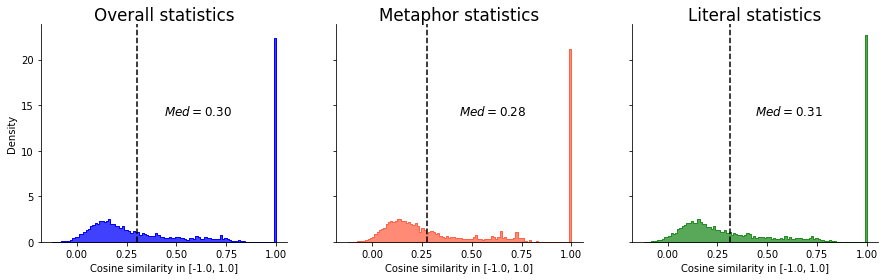

In [22]:
display_res = vua_results[("word2vec", 'RoBERTa + only best')]
display_score_distribution(display_res['scores'], display_res['labels'])